In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [172]:
datadir ='/Users/francesco/Desktop/Data/'

# Read the dataframes
df_bed = xr.open_dataset(datadir + 'BedMachineAntarctica-v3.nc')
df_melt = xr.open_dataset(datadir + 'bmelt_bmachine_grid_v1.nc')

#Adding the names of the glaciers, in order to select later the interesting ones
df_names = pd.read_csv(datadir + 'Merged_Integrated_melt_rates.csv')

In [173]:
#Extracting the variables

thickness = df_bed.thickness #dim -> (x,y)
melt = df_melt.melt #dim -> (t,x,y)

In [174]:
x = df_bed.x
y = df_bed.y
time = df_melt.time

In [175]:
# Plot the bed with the meshgrid

''' 
#Creatinng the mesh grid
coord = x.values
X, Y = np.meshgrid(coord, coord)


plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, bed, cmap='gist_earth')
plt.colorbar()
plt.show()
'''


" \n#Creatinng the mesh grid\ncoord = x.values\nX, Y = np.meshgrid(coord, coord)\n\n\nplt.figure(figsize=(10,10))\nplt.pcolormesh(X, Y, bed, cmap='gist_earth')\nplt.colorbar()\nplt.show()\n"

In [176]:
#Now I want to select the areas of the region of interest, and there I want to calculate the basal melt
#just for the thickest part of the glacier, i.e. the part of the glacier where the thickness is above the mean value

In [177]:
import glob
import pandas as pd
import os
from shapely.geometry import shape
import csv
#from mapxy import mapxy
import pyproj
#from ps_latlon_conversion import xyscale_south
import pyproj
#import ogr
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape

In [178]:
#get information from the shp file

path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop/Data/ice_shelf.shp'

ids = []
Names = []
lat_lon_coords = []
regions = []
boundaries = []
areas = []


#Here i just uses the first tif file to get the information, so 1992
file_tif = path_to_tif + 'melt_' + str(1992) + '_warp_ps.tif'
print(file_tif)


shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])


for feature in shapefile:


    id = feature['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    region = feature['properties']['regions']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    #thickness = feature['properties']['thickness_']

    bounds=shape(geometry).bounds
    xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]

    area_temp = np.abs((xmax-xmin)*(ymax-ymin))

    #Taking the info
    ids.append(id)
    Names.append(name)
    lat_lon_coords.append([lat,lon])
    regions.append(region)
    boundaries.append([xmin,xmax,ymin,ymax])
    areas.append(area_temp)


/Users/francesco/Desktop/Data/GEOTIFFs/melt_1992_warp_ps.tif
{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'f

In [179]:
#This block of code is to calculate the mean thickness and the mean melt for the thickest part of the glacier.
#Is commented since the output is already saved in the csv file


#The idea is to create a loop that goes through all the glaciers, 18 minuti
#and for each glacier it creates a mask, and then it calculates the mean thickness and the mean melt for the thickest part of the glacier

''' 
Years = np.arange(1992, 2018, 1)
thickness_mean = np.zeros(len(ids))
melt_mean = np.zeros((len(ids), len(time)))
print(np.shape(melt_mean))


for glacier in range(0, len(ids)):
    x_min , x_max, y_min, y_max =  boundaries[glacier]
    mask = (x > x_min) & (x < x_max) & (y > y_min) & (y < y_max)
    print('Glacier number: ', glacier)
    
    # index both thickness and melt using the mask
    thickness_roi = thickness.where(mask, drop=True)
    thickness_mean_roi = np.mean(thickness_roi)
    thickness_mean[glacier] = thickness_mean_roi

    
    for t in range(0, len(time)):
        melt_roi = melt[t].where(mask, drop=True)
        melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
        melt_mean[glacier, t] = melt_mean_temp

'''



(183, 26)
Glacier number:  0
Glacier number:  1
Glacier number:  2
Glacier number:  3
Glacier number:  4
Glacier number:  5
Glacier number:  6
Glacier number:  7
Glacier number:  8


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  9
Glacier number:  10
Glacier number:  11


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  12
Glacier number:  13


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  14


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  15
Glacier number:  16
Glacier number:  17
Glacier number:  18


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  19
Glacier number:  20


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  21


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  22


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  23


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  24
Glacier number:  25


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  26
Glacier number:  27
Glacier number:  28
Glacier number:  29
Glacier number:  30


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  31


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  32
Glacier number:  33
Glacier number:  34
Glacier number:  35
Glacier number:  36
Glacier number:  37
Glacier number:  38
Glacier number:  39
Glacier number:  40
Glacier number:  41
Glacier number:  42
Glacier number:  43


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  44
Glacier number:  45
Glacier number:  46
Glacier number:  47
Glacier number:  48


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  49
Glacier number:  50
Glacier number:  51
Glacier number:  52
Glacier number:  53
Glacier number:  54
Glacier number:  55
Glacier number:  56
Glacier number:  57
Glacier number:  58
Glacier number:  59
Glacier number:  60


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  61
Glacier number:  62
Glacier number:  63
Glacier number:  64
Glacier number:  65
Glacier number:  66
Glacier number:  67
Glacier number:  68
Glacier number:  69
Glacier number:  70
Glacier number:  71
Glacier number:  72
Glacier number:  73
Glacier number:  74
Glacier number:  75
Glacier number:  76


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  77
Glacier number:  78
Glacier number:  79
Glacier number:  80
Glacier number:  81
Glacier number:  82
Glacier number:  83
Glacier number:  84
Glacier number:  85
Glacier number:  86
Glacier number:  87
Glacier number:  88
Glacier number:  89
Glacier number:  90
Glacier number:  91
Glacier number:  92
Glacier number:  93


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  94


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  95
Glacier number:  96
Glacier number:  97
Glacier number:  98


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  99
Glacier number:  100
Glacier number:  101
Glacier number:  102
Glacier number:  103
Glacier number:  104
Glacier number:  105
Glacier number:  106
Glacier number:  107
Glacier number:  108
Glacier number:  109
Glacier number:  110
Glacier number:  111
Glacier number:  112
Glacier number:  113


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  114
Glacier number:  115
Glacier number:  116
Glacier number:  117
Glacier number:  118
Glacier number:  119
Glacier number:  120
Glacier number:  121
Glacier number:  122


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  123
Glacier number:  124
Glacier number:  125
Glacier number:  126
Glacier number:  127
Glacier number:  128
Glacier number:  129
Glacier number:  130
Glacier number:  131
Glacier number:  132
Glacier number:  133
Glacier number:  134
Glacier number:  135
Glacier number:  136


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  137
Glacier number:  138


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  139
Glacier number:  140


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  141
Glacier number:  142
Glacier number:  143
Glacier number:  144
Glacier number:  145
Glacier number:  146
Glacier number:  147
Glacier number:  148


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  149


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  150


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  151


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  152


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  153


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  154
Glacier number:  155


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  156


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  157
Glacier number:  158
Glacier number:  159
Glacier number:  160
Glacier number:  161


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  162


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  163


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  164


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  165


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  166


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  167
Glacier number:  168
Glacier number:  169
Glacier number:  170
Glacier number:  171
Glacier number:  172


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  173
Glacier number:  174
Glacier number:  175
Glacier number:  176
Glacier number:  177


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  178


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_roi))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_22227/4145602061.py:28: RuntimeWarning: Mean of empty slice
  melt_mean_temp = np.nanmean(melt_roi.where(thickness_roi > thickness_mean_r

Glacier number:  179
Glacier number:  180
Glacier number:  181
Glacier number:  182


In [192]:
# save as CSV file

''' 
Years = np.arange(1992, 2018, 1)
np.savetxt('thickness_and_basal_mean.csv', np.column_stack((thickness_mean, melt_mean)), delimiter=',')
np.savetxt('melt_mean_1.csv', melt_mean, delimiter=',', header=','.join(map(str, Years)))
np.savetxt('thickness_mean_1.csv', thickness_mean, delimiter=',', header=','.join(map(str, Names)))

'''

In [197]:
#reading the csv file and extracting the variables
melt_mean = pd.read_csv(data_dir_2 + 'melt_mean_1.csv')
thickness_mean = pd.read_csv(data_dir_2 + 'thickness_mean_1.csv')



#Here I import the dataset for the glaciers that I am interested in
data_dir_2 = '/Users/francesco/Desktop/Thesis/Bed_machine/'

df_names = pd.read_csv(datadir + 'Merged_Integrated_melt_rates.csv')
Glaciers = df_names['Names']

interesting_glaciers = ['Pine_Island', 'Thwaites', 'Crosson', 'Dotson', 'Getz_2', 'Venable']
interesting_indices = np.where(np.isin(Glaciers, interesting_glaciers))[0]


In [198]:


print(interesting_indices)
print(Glaciers[interesting_indices])
len(Glaciers[interesting_indices])

[43 61 67 68 69 71]
43         Getz_2
61        Venable
67    Pine_Island
68       Thwaites
69        Crosson
71         Dotson
Name: Names, dtype: object


6

In [199]:
#Take the first raw of the dataframe melt_mean


df_interesting_glaciers = melt_mean.iloc[interesting_indices]
df_interesting_glaciers


,# 1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,-3.605442,-2.884086,-2.468552,-4.068516,-4.463484,-1.865358,-6.969004,-5.466586,-4.411549,-4.049332,...,-6.059647,-4.980170,-4.262447,-0.610405,-3.866952,-2.053005,-2.829292,-1.272592,-4.511341,-1.349952
67,-21.449914,-20.570059,-19.899727,-23.212189,-20.787389,-19.075990,-22.901829,-18.525763,-20.380371,-21.462235,...,-24.523703,-19.307042,-20.636665,-17.018780,-13.666499,-17.654303,-16.968275,-15.354581,-16.816891,-17.005557
68,-24.447653,-32.818858,-28.520485,-36.063666,-29.334189,-31.533917,-36.432817,-24.824092,-29.109719,-30.906729,...,-42.560500,-32.235597,-29.586395,-22.604142,-2.746458,-2.770944,-4.112532,-1.635843,-1.486520,-2.152010
69,-15.067985,-21.842386,-16.456872,-23.358443,-19.444568,-16.617810,-21.323802,-18.283064,-19.254370,-20.444287,...,-22.635928,-13.707167,-15.193405,-11.320781,-11.235661,-10.193431,-14.754618,-8.731806,-8.022121,-9.182577
71,-13.143792,-17.026532,-13.825222,-18.209323,-15.392142,-9.383227,-15.989702,-13.187187,-16.124847,-15.330571,...,-19.842242,-14.658020,-12.541165,-11.534834,-11.247263,-10.096984,-12.121224,-9.265471,-8.149614,-7.859727


In [200]:
#Calculate a linear regression of the melt rate for each glacier

from scipy import stats

lin_coeff = np.zeros((len(df_interesting_glaciers),2))
lin_reg = np.zeros((len(df_interesting_glaciers),len(Years)))
r_2 = np.zeros(len(df_interesting_glaciers))

for glacier in range(0, len(df_interesting_glaciers)):
    lin_coeff[glacier,:] = np.polyfit(Years, df_interesting_glaciers.iloc[glacier], 1)
    lin_reg[glacier,:] = np.polyval(lin_coeff[glacier,:], Years)
    r_2[glacier] = stats.linregress(Years, df_interesting_glaciers.iloc[glacier])[2]**2


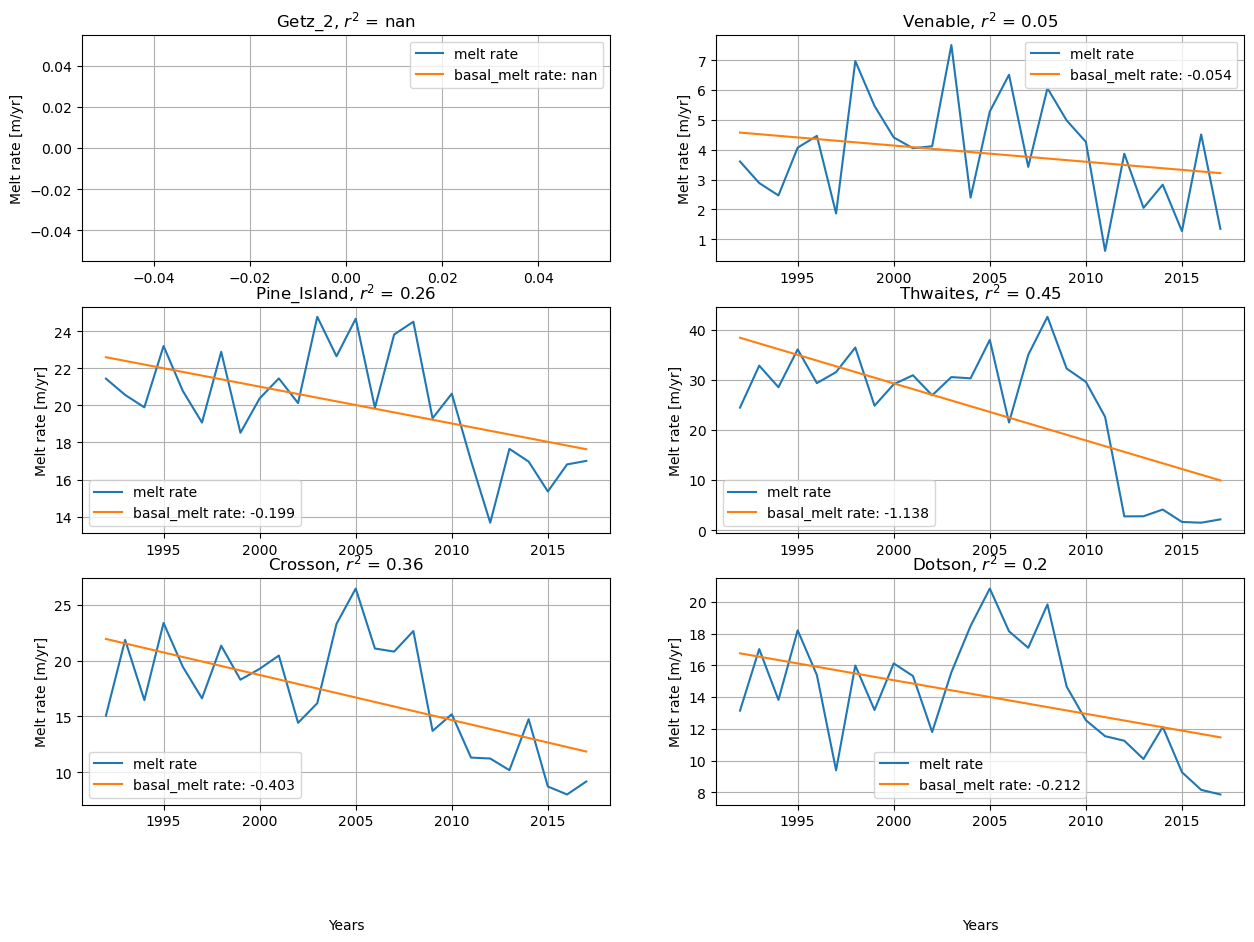

In [201]:
#Make a graph containing the melt rate for the glaciers of interest, for each glacier (6 graphs on one same figure)

fig, ax = plt.subplots(3,2,figsize=(15, 10))
ax = ax.ravel()

for glacier in range(0, len(df_interesting_glaciers)):

    ax[glacier].plot(Years, -df_interesting_glaciers.iloc[glacier], label='melt rate')
    ax[glacier].plot(Years, -lin_reg[glacier,:], label='basal_melt rate: ' + str(round(-lin_coeff[glacier,0],3)))
    ax[glacier].set_title(Glaciers[interesting_indices[glacier]] + ', $r^2$ = ' + str(round(r_2[glacier],2)))
    ax[glacier].set_xlabel('Years')
    ax[glacier].set_ylabel('Melt rate [m/yr]')
    ax[glacier].xaxis.set_label_coords(0.5, -0.5)
    ax[glacier].legend()
    ax[glacier].grid()

plt.savefig('Melt_rate_glaciers_roi.png', dpi=300, bbox_inches='tight')


